In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

sys.path.append('../src')
from recommenders.recommender_system import RecommenderSystem
from recommenders.item_based_rs import ItemBasedRecommenderSystem
from utils.similarity_measure import cosine_similarity, adjusted_cosine_similarity
from utils.data_splitter import get_data

# Load data, model

In [2]:
train_df, test_df = get_data(data_path='../data/ratings.csv', train_over_test_ratio=0.2, random_state=42)

In [4]:
item_based_rs_cosine = RecommenderSystem.load_model(path='../saved_models/item_based_rs_cosine.pkl')

# Experiments

## 1. Effect of Similarity Algorithm

## 2.  Sensitivity of Training/Test Ratio

## 3.  Experiments with neighborhood size

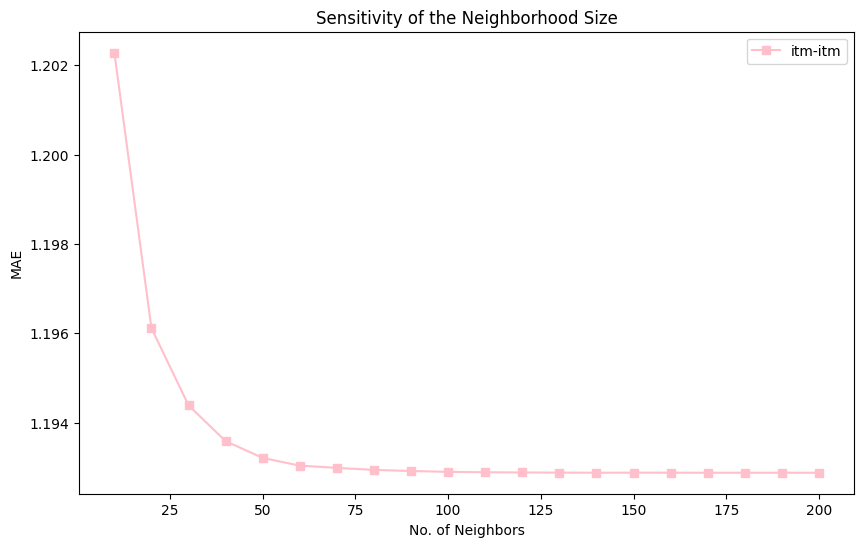

In [ ]:
MAE_for_each_k = []
for k_neighbors in range(10, 210, 10):
    MAE_for_each_k.append(item_based_rs_cosine.evaluate(test_df, k_neighbors=k_neighbors, metric=mean_absolute_error))\
    
fig_ex_3 = plt.figure(figsize=(10, 6))
plt.plot([k_neighbors for k_neighbors in range(10, 210, 10)], MAE_for_each_k, 's-', color='pink', label='itm-itm')
plt.title('Sensitivity of the Neighborhood Size')
plt.xlabel('No. of Neighbors')
plt.ylabel('MAE')
plt.legend()



In [ ]:
fig_ex_3.savefig('../figures/ex_3.png')